# CITS5014/15 Research Project

### Name: Peter Millitz [23088298]   Date: 17/10/2025

# Deep-Learning-Based Techniques for Ship Object Detection and Classification Using Complex-Valued SAR Imagery

## 1. Introduction

This research seeks to investigate the use of high-resolution complex-valued SLC data products from space-based SAR imagery for the tasks of ship detection, classification, and vessel regression using Deep Learning (DL). The basis for this investigation is the hypothesis that fully leveraging the information in the inherently complex-valued SAR imagery should naturally lead to superior model performance compared to real-valued networks. The underlying motivation is to achieve tangible improvements in the performance of existing SAR ship detection models used for maritime surveillance of IUU fishing activity.

## 2. The SARFish dataset

### 2.1 Overview

SARFish is an imagery dataset for the purpose of training, validating and testing supervised machine learning models on the tasks of ship detection, classification and vessel length regression. SARFish builds on the work of the xView3-SAR dataset by expanding the imagery data to include Single Look Complex (SLC) as well as Ground Range Detected (GRD) imagery data taken directly from the European Space Agency (ESA) Copernicus Programme Open Access Hub Website.  

The pre-processing applied to the Sentinel-1 images to the SARFish dataset was chosen to be deliberately minimal. The only operations applied to the SARFish data have been those necessary to make the images usable for computer vison tasks and include flipping, debursting and no-data masking. The philosophy was to provide GRD and SLC data in a format as close as practicable to the Sentinel-1 data that can be downloaded from Copernicus.  

The three operations applied post download are describe below:  

1. **Flipping:** Flipping was applied to both GRD and SLC products. Due to the acquisition methodology, raw images appear as mirror images of the surface of the Earth. This parity inversion between raw images and real-world coordinates is accounted for by reversing the image and its associated ground control points along the range or x-axis. 

2. **Debursting:** Debursting was applied only to SLC products. Sentinel-1 SLC products are provided as sets of 3 "swaths" per channel per scene. These swaths consist of "sub-swaths" or "bursts" which are overlapping segments of the image. The process of de-bursting is the alignment of these bursts into a contiguous image. This was done to create a one-to-one correspondence between the objects in each swath and the features on the Earth to which they correspond. It is important to note that as the deburst images are concatenations of bursts which themselves are individual SAR images, there are significant phase discontinuities on the boundaries of the bursts. It was decided for the purposes of this dataset that the bursts within the individual swaths should be merged rather than being split into separate images.

3. **No data masking:** No data masking was applied to both GRD and SLC products. Invalid pixels in the image have been masked using a 'no data' mask.

### 2.2. Dataset download

All SLC (and corresponding GRD) products from the 50 scenes that comprise the 'validation' partition of the SARFish dataset, were downloaded for this project. The SARFish dataset resides in a Hugging Face repository available for download at: https://huggingface.co/datasets/ConnorLuckettDSTG/SARFish. The validation partition was chosen because of the high prevalence of associated labelling where true vessel detections were of `HIGH` and `MEDIUM` confidence and bounding box coordinates were present. In contrast, the 'train' partition, although having many more scenes, entirely lacked labels with 'HIGH' confidence true vessel detections. Moreover, the majority of MEDIUM confidence labels did not have bounding boxes. The exact selection criteria for SLC images based on associated groundtruth labels is shown in Table 1 below.

Table 1. Label criteria required for SLC image selection.

|  Attribute |      Value(s)     |
|:-----------|:------------------|
|  is_vessel |        True       |
| is_fishing |   True, False     |
| confidence |   HIGH, MEDIUM    |
|     top    |    not missing    |
|     left   |    not missing    |
|   bottom   |    not missing    |
|    right   |    not missing    |

A script, kindly supplied by one of the principal authors of the dataset^1, was customised to selectively download 50 SLC scenes selected from the validation partition (see script: *downloader/download_specific_files_from_the_SARFish_dataset_mod.py*). The script requires a specific python environment setup. The *requirements.txt* file used to create the python environment is included in the downloader directory.

* Note: due to the debursting operation, each scene comprises three separate swaths (with small overlap), so the total number of images downloaded is actually 150.

[1] Connor Luckett, connor.luckett@defence.cgov.au

Store a list of qualifying validation partition scenes:

In [1]:
# Create a list of scene ids ('validation' partition) from the 50 selected scenes in the SARFish dataset on Hugging Face
scene_list_val = ["0157baf3866b2cf9v","0d8ed29b0760dc59v","0e309957cef7bdc8v","128443d1e98e2839v","13dd786ee6c95e06v","204e657a411faf4dv","264ed833a13b7f2av","2e80028071b89173v","335f9a411884e9cbv","36076e547370064ev",
                  "377410f6ab9824dfv","3808f5703f0920bfv","39268d50efe8dae9v","3ceef682fbe4930av","3fe00bf7beab8812v","487b4884f467c94av","4a97701b4bd81bf7v","4da9db72dea50504v","590dd08f71056cacv","5c3d986db930f848v",
                  "5e9a2c1bcf179e9bv","65d6f6baee882077v","6a2b6ddecd398c6fv","758991708403f218v","75c03770095c6d9ev","7b7e837a7ac5a880v","8204efcfe9f09f94v","844545c005776fb1v","94dca5e4de2edcf8v","9a5aa7310c195f14v",
                  "9b89b9dcce7dc85ev","9c418af4acd217d1v","9ea5029406691ce4v","a1a21a222e244555v","a6073537a4ea5fb9v","a9a58462f221a9eev","acf76647ba3f524bv","b1844cde847a3942v","c5ea6da5405bfac0v","c8bbfb37522617e9v",
                  "cd36e75010a021f7v","cd4f6ff86f9f5991v","cdc04ca397865356v","e40c9251a4fce150v","eeddcc0db3cff0d8v","f298dbd78ef977d5v","f9eb760aaf6e798dv","fc2f57371370c521v","fc483682c621b54bv","fe6a8d80fb5ebb8ev"]

## 3. Setup

In [2]:
from pathlib import Path
import os
from time import time

import numpy as np # np.__version__ = 1.26.4 (had to downgrade to version < 2.0)
import pandas as pd
import matplotlib.pyplot as plt # Added by PJM
import yaml
from GeoTiff import load_GeoTiff
from complex_scale_and_norm import process_complex_data
from batch_sar_processing import *

%gui qt
from visualise_labels import scale_sentinel_1_image, SARFish_Plot
#from SARFish_metric import score

pd.set_option('display.max_colwidth', None)

## 4. Exploratory Data Analysis

### 4.1 Statistical summary

Compute summary statistics for each SLC VH-polarisation image (3 images per swath, total of 150 images). 

(Original images are stored as GeoTIFF files and converted to numpy arrays. The arrays are saved to disk for later use.)

In [3]:
# Compute statistics for all SLC VH-polarisation .tiff image files in SLC validation partition
#!./compute_sar_stats.py --q --pattern slc-vh --save-array /mnt/h/SARFish/SLC/validation/

# Add scene ID column to output file ('slc-vh_stats.csv') saved in current directory as ('slc-vh_stats_mod.csv')
#!./add_scene_id.py

Read the output into a dataframe and display the full results:

In [4]:
# Load the slc-vh stats tabulation  into a dataframe and display it
df_slc_vh_stats_mod = pd.read_csv('slc-vh_stats_mod.csv')
df_slc_vh_stats_mod.head()

,scene_id,safe_directory,filename,valid_pixels,nan_count,zero_count,valid_percentage,real_mean,real_std,real_min,...,amplitude_min,amplitude_max,amplitude_median,phase_mean,phase_std,phase_min,phase_max,phase_circular_mean,phase_circular_variance,phase_circular_std
0,335f9a411884e9cbv,S1B_IW_SLC__1SDV_20201018T054753_20201018T054820_023863_02D58D_8CE7.SAFE,s1b-iw1-slc-vh-20201018t054754-20201018t054819-023863-02d58d-001_SARFish.tiff,285029283,0,36226849,100.0,-0.002757,14.997891,-3529.0,...,0.0,6096.8047,13.892444,0.078970,1.700495,-3.138905,3.141593,0.010266,0.873502,2.033485
1,335f9a411884e9cbv,S1B_IW_SLC__1SDV_20201018T054753_20201018T054820_023863_02D58D_8CE7.SAFE,s1b-iw2-slc-vh-20201018t054755-20201018t054820-023863-02d58d-002_SARFish.tiff,331309224,0,34412972,100.0,-0.007101,23.076190,-6541.0,...,0.0,9894.8570,15.811388,0.068502,1.721079,-3.138719,3.141593,-0.013893,0.895217,2.124083
2,335f9a411884e9cbv,S1B_IW_SLC__1SDV_20201018T054753_20201018T054820_023863_02D58D_8CE7.SAFE,s1b-iw3-slc-vh-20201018t054753-20201018t054818-023863-02d58d-003_SARFish.tiff,318382830,0,31162632,100.0,0.002566,18.202345,-4646.0,...,0.0,6370.0454,13.341663,0.084060,1.727526,-3.138477,3.141593,0.001231,0.901376,2.152413
3,3808f5703f0920bfv,S1A_IW_SLC__1SDV_20200421T050338_20200421T050406_032221_03BA14_7DD2.SAFE,s1a-iw3-slc-vh-20200421t050338-20200421t050406-032221-03ba14-003_SARFish.tiff,341956342,0,20759728,100.0,0.004107,30.860744,-3417.0,...,0.0,5437.0166,24.186773,0.066700,1.764073,-3.140158,3.141593,0.037443,0.940950,2.378812
4,3808f5703f0920bfv,S1A_IW_SLC__1SDV_20200421T050338_20200421T050406_032221_03BA14_7DD2.SAFE,s1a-iw1-slc-vh-20200421t050339-20200421t050404-032221-03ba14-001_SARFish.tiff,272711592,0,22474879,100.0,-0.002444,23.275122,-4129.0,...,0.0,5646.9604,18.248287,0.061543,1.741120,-3.140470,3.141593,-0.018338,0.916789,2.229967


Display an abbreviated version of the dataframe showing important columns only:

In [5]:
# Display abbreviated list of columns
df_display = (df_slc_vh_stats_mod[['scene_id', 'filename', 'valid_pixels', 'nan_count','zero_count',
                                   'amplitude_mean','amplitude_std','amplitude_min','amplitude_max','amplitude_median',
                                   'phase_circular_mean','phase_min', 'phase_max', 'phase_circular_std']]
              .assign(filename=lambda x: x['filename'].str[:14] + '...'))
df_display

,scene_id,filename,valid_pixels,nan_count,zero_count,amplitude_mean,amplitude_std,amplitude_min,amplitude_max,amplitude_median,phase_circular_mean,phase_min,phase_max,phase_circular_std
0,335f9a411884e9cbv,s1b-iw1-slc-vh...,285029283,0,36226849,15.748271,14.217105,0.0,6096.8047,13.892444,0.010266,-3.138905,3.141593,2.033485
1,335f9a411884e9cbv,s1b-iw2-slc-vh...,331309224,0,34412972,22.926825,23.219760,0.0,9894.8570,15.811388,-0.013893,-3.138719,3.141593,2.124083
2,335f9a411884e9cbv,s1b-iw3-slc-vh...,318382830,0,31162632,18.143103,18.260683,0.0,6370.0454,13.341663,0.001231,-3.138477,3.141593,2.152413
3,3808f5703f0920bfv,s1a-iw3-slc-vh...,341956342,0,20759728,32.412090,29.226326,0.0,5437.0166,24.186773,0.037443,-3.140158,3.141593,2.378812
4,3808f5703f0920bfv,s1a-iw1-slc-vh...,272711592,0,22474879,23.730442,22.816694,0.0,5646.9604,18.248287,-0.018338,-3.140470,3.141593,2.229967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,65d6f6baee882077v,s1b-iw2-slc-vh...,329083515,0,29897941,31.288660,27.120457,0.0,6778.0264,25.553865,-0.009270,-3.139404,3.141593,2.189406
146,65d6f6baee882077v,s1b-iw3-slc-vh...,316267371,0,26182545,32.780293,26.831316,0.0,6383.5500,28.301943,0.001842,-3.140020,3.141593,2.231774
147,65d6f6baee882077v,s1b-iw1-slc-vh...,284636268,0,35120348,20.447000,19.692966,0.0,8834.3000,16.278820,0.017757,-3.139355,3.141593,2.042816
148,65d6f6baee882077v,s1b-iw2-slc-vh...,330781988,0,32423713,32.277737,25.245028,0.0,9521.1690,28.319605,0.003472,-3.140754,3.141593,2.155560


Determine the global minimum and maximum values of amplitude and phase across the 150 images

In [6]:
cols = ['amplitude_min','amplitude_max','phase_min', 'phase_max']
column_maximums = df_display[cols].max()
pd.set_option('display.precision', 10)
print(column_maximums)

amplitude_min        0.0000000
amplitude_max    22862.6000000
phase_min           -3.1234128
phase_max            3.1415927
dtype: float64


Examine one image array:

In [7]:
# Load one full-size slc-vh image array (scene_id = '5c3d986db930f848v', swath 2 )
slc_data = np.load('/mnt/h/SARFISH/SLC/validation/arrays/s1b-iw2-slc-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.npy')

In [8]:
print(f"slc_data size:{slc_data.size}, slc_data.shape: {slc_data.shape}, slc_data dtype:{slc_data.dtype}")

slc_data size:299990055, slc_data.shape: (12237, 24515), slc_data dtype:complex64


In [9]:
# Display the image stats
df_display[(df_display["scene_id"] == "5c3d986db930f848v") & (df_display["filename"].str[:7] == "s1b-iw2")]

,scene_id,filename,valid_pixels,nan_count,zero_count,amplitude_mean,amplitude_std,amplitude_min,amplitude_max,amplitude_median,phase_circular_mean,phase_min,phase_max,phase_circular_std
23,5c3d986db930f848v,s1b-iw2-slc-vh...,299990055,0,4519704,19.262346,16.159203,0.0,2684.2402,15.0,-0.06741247,-3.1386771,3.1415927,2.8861689803


Plot histograms of the amplitude and phase diistribution:

In [10]:
# Extract the raw amplitude and phase data   
vh_mag = np.abs(slc_data)
vh_phase = np.angle(slc_data)

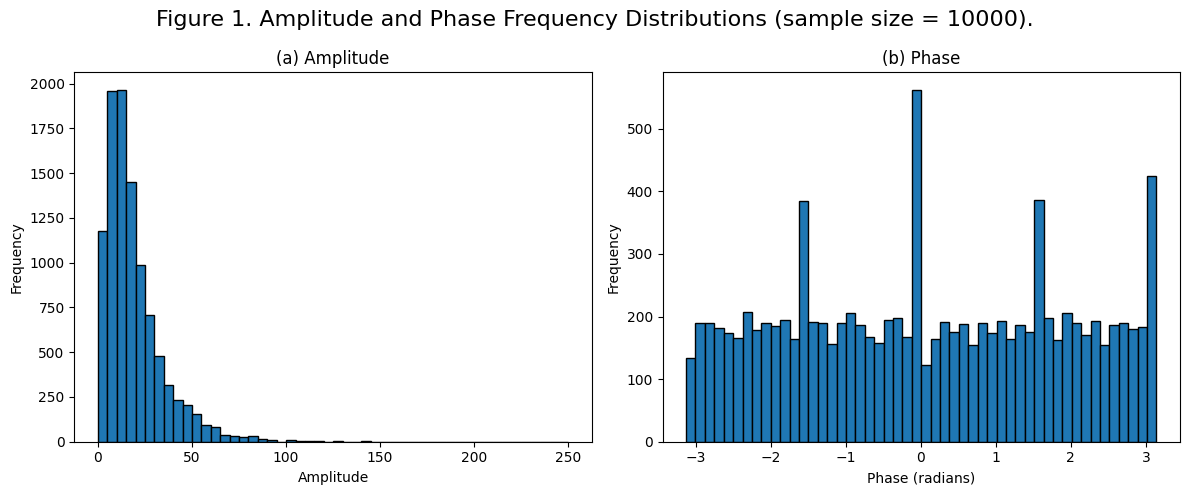

In [11]:
# Plot histograms of raw amplitude and phase (randomly sampled)
sample_size = 10000
vh_mag_sample = np.random.choice(vh_mag.ravel(), sample_size, replace=False)
vh_phase_sample = np.random.choice(vh_phase.ravel(), sample_size, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram on the first subplot
axes[0].hist(vh_mag_sample, bins=50, edgecolor='black')
axes[0].set_title("(a) Amplitude")
axes[0].set_xlabel("Amplitude")
axes[0].set_ylabel("Frequency")

# Plot histogram on the second subplot
axes[1].hist(vh_phase_sample, bins=50, edgecolor='black')
axes[1].set_title("(b) Phase")
axes[1].set_xlabel("Phase (radians)")
axes[1].set_ylabel("Frequency")

# Add super title
fig.suptitle("Figure 1. Amplitude and Phase Frequency Distributions (sample size = 10000).", fontsize=16)

# Improve layout and show plot
plt.tight_layout()
plt.show()

slc_data = None # free up memory

**Observations:**
* The actual amplitude range for this image is [0.0, 2684.2] and the actual mean/median values are 19.3 and 15.0 respectively. The distribution clearly is long-tailed (Figure 1(a)) and is a typical characteristic.
* Phase range is centred on zero radians with values in the range $(-\pi, \pi]$. Distribution is fairly uniform across the range but with consistently high frequency peaks around $0$, $\pm\pi/2$ and $\pi$ (Figure 1(b)).
* phase_max is effectively $+\pi$ (discounting a small floating-point precision error) while the minimum phase is very close to $-\pi$. These min/max values are characteristic across the 150 images.

**Pre-processing recommendations: Scaling and Normalisation**
* **Amplitude:** Logarithmic (decibel) transformation to compress dynamic range:
  
$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad vh\_mag\_db = 20\log_{10}(vh\_mag + \epsilon)$,

$\quad$ where $\epsilon$ is some small number (e.g. $10^-6$) to prevent log(0) errors, then normalise to [0, 1] using min/max scaling (using global min/max values).  

* **Phase:** The focus is on maintaining relative structure; only requires normalisation to map range within [0, 1]) for YOLOv11 compatibility. Phase is inherently circular/periodic. Representing phase as sine/cosine components respects the circular nature of phase and can be more suitable for training a neural network (eliminates the phase wraparound problem while keeping values in a well-behaved range). However, this representation still requires re-mappping values for YOLO-compatibility ([-1, 1] -> [0,1]):

 $\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad phase\_sin\_norm = \frac{(phase\_sin + 1)}{2}\quad\text{and}$
 
 $\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad phase\_cos\_norm = \frac{(phase\_cos + 1)}{2}$.

### 4.2 Training labels

Examine the SLC 'validation' partition labels

In [13]:
# Load the SLC validation labels into a dataframe
df_labels_val = pd.read_csv('~/CITS5014/SARFish/working/labels/validation/SLC/SLC_validation_labels.csv')
# Display a few lines
df_labels_val

,partition,product_type,scene_id,detect_id,SLC_product_identifier,swath_index,detect_lat,detect_lon,detect_scene_column,detect_scene_row,...,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
0,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.60344616000000428357_-20.89814321000000063577,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.603446160,-20.898143210,18083.0,5388.0,...,18079.0,5387.0,18087.0,NaN,manual,True,NaN,0.1307769616,0.1097268307,LOW
1,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.60102723999999341231_-20.90357632999999992762,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.601027240,-20.903576330,18131.0,5365.0,...,18124.0,5363.0,18138.0,NaN,manual,True,NaN,0.1422627235,0.0710514325,MEDIUM
2,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.17134473999999499938_-21.09210240000000169402,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.171344740,-21.092102400,17649.0,1860.0,...,17643.0,1859.0,17652.0,NaN,manual,True,NaN,0.0418837330,0.5096837748,MEDIUM
3,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.17062706000000105178_-21.09188649000000026490,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.170627060,-21.091886490,17642.0,1855.0,...,17635.0,1852.0,17649.0,NaN,manual,True,NaN,0.0448946415,0.5021807889,MEDIUM
4,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.70719721999999762829_-20.71366400000000140835,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.707197220,-20.713664000,16672.0,6335.0,...,16655.0,6331.0,16687.0,NaN,manual,True,NaN,0.0154433573,2.7897569722,MEDIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19181,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.46657020399999993288_003.39077283399999984681,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.466570204,3.390772834,11095.0,9420.0,...,11084.0,9418.0,11105.0,41.66266083,manual,True,NaN,0.0129786373,0.4586791222,MEDIUM
19182,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.46965017399999986480_003.38507763299999986373,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.469650174,3.385077633,11299.0,9435.0,...,11285.0,9432.0,11312.0,164.11293480,manual,True,NaN,0.1093857865,0.1949056056,MEDIUM
19183,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.28999598099999968071_003.23360257100000003661,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.289995981,3.233602571,15029.0,7806.0,...,14983.0,7799.0,15071.0,234.08431390,ais/manual,True,False,9999.9900000000,9999.9900000000,HIGH
19184,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.36177788400000032709_003.31700163200000019970,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.361777884,3.317001632,12791.0,8493.0,...,12748.0,8488.0,12835.0,109.96308340,ais/manual,True,False,4.3938699883,4.7675374629,HIGH


In [14]:
# Check for duplicates
duplicates_val = df_labels_val[df_labels_val.duplicated(subset=['detect_id'], keep=False)]
# Count the number of duplicate detection IDs
duplicates_val['detect_id'].value_counts()

detect_id
5c3d986db930f848v_065.43694542999999441690_-21.17495764999999963152    2
758991708403f218v_004.27108497299999978480_008.33741750599999953408    2
844545c005776fb1v_005.60443800699999972181_005.19602864300000000242    2
844545c005776fb1v_004.77571908799999977902_005.36598942000000000974    2
844545c005776fb1v_004.81127173099999971839_005.35755161600000029409    2
                                                                      ..
c5ea6da5405bfac0v_057.29171715999999747737_008.99094423100000028626    2
c5ea6da5405bfac0v_057.08132639000000096985_009.03207429200000078140    2
a9a58462f221a9eev_056.83245433999999818298_007.66902659700000022269    2
f9eb760aaf6e798dv_044.78420882999999719232_013.25889931999999937773    2
377410f6ab9824dfv_006.02922705100000033696_003.64273458300000019250    2
Name: count, Length: 280, dtype: int64

In [15]:
# Filter for true vessels detections which are either fishing or not and for which there is HIGH or MEDIUM confidence and where the pixels locations of all four corners of the bounding box are not missing
col_range = ['top', 'left', 'bottom', 'right'] # bounding box corner pixels

df_labels_val_filt = df_labels_val[ ( (df_labels_val['is_vessel'] == True) & (df_labels_val['is_fishing'].notnull() ) &  
                                    ( (df_labels_val['confidence'] == 'HIGH') | (df_labels_val['confidence'] == 'MEDIUM') ) & 
                                       df_labels_val[col_range].notnull().all(axis=1)) ]                                   
# Display a few values
df_labels_val_filt

,partition,product_type,scene_id,detect_id,SLC_product_identifier,swath_index,detect_lat,detect_lon,detect_scene_column,detect_scene_row,...,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
22,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.98324671999999679883_-20.70595078999999927305,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.983246720,-20.705950790,18289.0,8503.0,...,18282.0,8500.0,18293.0,9.97000000,ais/manual,True,True,9999.9900000000,9999.9900000000,HIGH
23,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.60488521000000616823_-21.09645533999999855723,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.604885210,-21.096455340,20344.0,5257.0,...,20335.0,5255.0,20350.0,11.51000000,ais/manual,True,True,7.9485651366,7.5869432758,HIGH
25,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_065.96593518000000244683_-20.62517562000000026501,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,65.965935180,-20.625175620,17290.0,8426.0,...,17279.0,8421.0,17298.0,11.10000000,ais/manual,True,True,9999.9900000000,9999.9900000000,HIGH
30,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_066.13229690999999377254_-19.98992583000000067273,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,66.132296910,-19.989925830,11494.0,10195.0,...,11489.0,10194.0,11497.0,14.98000000,ais/manual,True,True,4.9784111927,5.2402711048,HIGH
33,validation,SLC,5c3d986db930f848v,5c3d986db930f848v_066.33721583999999893422_-18.87526499999999884949,S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2,1,66.337215840,-18.875265000,1589.0,12651.0,...,1576.0,12645.0,1599.0,14.80000000,ais/manual,True,True,9999.9900000000,9999.9900000000,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19179,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.33977017199999970387_003.35668044700000001157,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.339770172,3.356680447,11364.0,8385.0,...,11345.0,8382.0,11384.0,64.87461302,ais/manual,True,False,6.5084871675,6.6980791736,HIGH
19180,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.29591264799999983381_003.33278283300000000011,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.295912648,3.332782833,11848.0,8008.0,...,11816.0,8003.0,11880.0,92.09711576,ais/manual,True,False,9999.9900000000,9999.9900000000,HIGH
19183,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.28999598099999968071_003.23360257100000003661,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.289995981,3.233602571,15029.0,7806.0,...,14983.0,7799.0,15071.0,234.08431390,ais/manual,True,False,9999.9900000000,9999.9900000000,HIGH
19184,validation,SLC,377410f6ab9824dfv,377410f6ab9824dfv_006.36177788400000032709_003.31700163200000019970,S1A_IW_SLC__1SDV_20200407T052956_20200407T053026_032017_03B2E2_18FA,3,6.361777884,3.317001632,12791.0,8493.0,...,12748.0,8488.0,12835.0,109.96308340,ais/manual,True,False,4.3938699883,4.7675374629,HIGH


In [19]:
# Display abbreviated column verson of previous dataframe
df_labels_val_filt_abv = (df_labels_val_filt[['partition','product_type','scene_id','detect_id','swath_index',
                                     'detect_scene_column','detect_scene_row','top','left','bottom','right',
                                     'vessel_length_m','is_vessel','is_fishing','confidence']]
                  .assign(detect_id=lambda x: '...' + x['detect_id'].str[-39:]))
# Display a few values
df_labels_val_filt_abv.head()

,partition,product_type,scene_id,detect_id,swath_index,detect_scene_column,detect_scene_row,top,left,bottom,right,vessel_length_m,is_vessel,is_fishing,confidence
22,validation,SLC,5c3d986db930f848v,...71999999679883_-20.70595078999999927305,1,18289.0,8503.0,8506.0,18282.0,8500.0,18293.0,9.97,True,True,HIGH
23,validation,SLC,5c3d986db930f848v,...21000000616823_-21.09645533999999855723,1,20344.0,5257.0,5259.0,20335.0,5255.0,20350.0,11.51,True,True,HIGH
25,validation,SLC,5c3d986db930f848v,...18000000244683_-20.62517562000000026501,1,17290.0,8426.0,8431.0,17279.0,8421.0,17298.0,11.10,True,True,HIGH
30,validation,SLC,5c3d986db930f848v,...90999999377254_-19.98992583000000067273,1,11494.0,10195.0,10196.0,11489.0,10194.0,11497.0,14.98,True,True,HIGH
33,validation,SLC,5c3d986db930f848v,...83999999893422_-18.87526499999999884949,1,1589.0,12651.0,12656.0,1576.0,12645.0,1599.0,14.80,True,True,HIGH


In [17]:
# Determine the number of unique scene_id/swath_index combinations present. This will indicate the total number of images that meet the selection criteria.
unique_combinations = df_labels_val_filt[['scene_id', 'swath_index']].drop_duplicates()
count_images = len(unique_combinations)
print(f"Number of unique scene_id/swath_index entries: {count_images}")

Number of unique scene_id/swath_index entries: 136


In [20]:
# Determine the number of 'HIGH' and 'MEDIUM' confidence labels (including duplicates) after filtering
count_labels = df_labels_val_filt['confidence'].value_counts()
print(count_labels[['HIGH', 'MEDIUM']])

confidence
HIGH      3807
MEDIUM      50
Name: count, dtype: int64


Comments:

* There are a total of **19,186** label entries (rows) in total encompassing 50 scenes. Of these, **280** have duplicated detection ids. This is attributed to the overlap between adjacent swaths i.e., a detection occurring in the overlap zone is recorded once, having a unique detection id, but is associated with both swaths and considered unique to each swath.
* There are a total of **3,857** labels spread across the 50 scenes, which meet the selection criteria. The overwhelming majority are 'HIGH' confidence labels (3,807).
* Note that although there are 50 qualifying scenes, not every swath associated with each scene contains qualifying annotations. It was found that 14 individual swaths did not, meaning the total number of qualifying images is actually **136** (not 50 x 3 = 150).


### 4.3. Load and display a SLC VH-polarisation image

Plot one swath of an SLC VH-polarisation scene from the validation partition, with 'HIGH' confidence labels.
(The same image in Secton 4.1 is used here again).

Note: The image is scaled, clipped, downsampled and the complex amplitude and phase data mapped into real intensity values for display purposes.

#### 4.3.1 Build the image filepath

In [21]:
# Load the envrionmnet.yaml file and set the SARFish data root directory
with open("environment.yaml", "r") as f:
    environment = yaml.safe_load(f)

SARFish_root_directory = environment['SARFish_root_directory']
os.environ['SARFISH_ROOT_DIRECTORY'] = SARFish_root_directory

In [22]:
# Read correspondences file
xView3_SLC_GRD_correspondences = pd.read_csv("~/CITS5014/SARFish/working/labels/xView3_SLC_GRD_correspondences.csv")

# Extract the validation partition row entry for scene_Id '5c3d986db930f848v' from the xView3_SLC_GRD_correspondences.csv file
correspondence = xView3_SLC_GRD_correspondences[xView3_SLC_GRD_correspondences['scene_id'] == '5c3d986db930f848v'].squeeze()
# Print extracted row entry details
correspondence

DATA_PARTITION                                                                                  validation
scene_id                                                                                 5c3d986db930f848v
GRD_product_identifier                 S1B_IW_GRDH_1SDV_20200803T075721_20200803T075746_022756_02B2FF_033A
GRD_md5sum                                                                3f8ec460304f087c8f9a59b7c0897561
GRD_vh                        s1b-iw-grd-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.tiff
GRD_vv                        s1b-iw-grd-vv-20200803t075721-20200803t075746-022756-02b2ff-001_SARFish.tiff
GRD_vh_annotation                      s1b-iw-grd-vh-20200803t075721-20200803t075746-022756-02b2ff-002.xml
GRD_vv_annotation                      s1b-iw-grd-vv-20200803t075721-20200803t075746-022756-02b2ff-001.xml
SLC_product_identifier                 S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2
SLC_md5sum                           

In [23]:
# Now build path to the SLC product

# Set the required swath index of the selected scene
swath_index = 2 # swath 2 of 3

measurement_path_SLC = Path(SARFish_root_directory, "SLC", correspondence['DATA_PARTITION'], 
                            f"{correspondence['SLC_product_identifier']}.SAFE",
                            "measurement", correspondence[f'SLC_swath_{swath_index}_vh'])
measurement_path_SLC

PosixPath('/mnt/h/SARFish/SLC/validation/S1B_IW_SLC__1SDV_20200803T075720_20200803T075748_022756_02B2FF_E5D2.SAFE/measurement/s1b-iw2-slc-vh-20200803t075721-20200803t075746-022756-02b2ff-002_SARFish.tiff')

#### 4.3.2 Load, prepare and plot the SLC image

In [24]:
# Set a scale factor to be used for downsampling the image for display
scale_factor = 2 # retain every other pixel

# Unpack image from GeoTIFF as a NumPy array
data_SLC, nodata_mask_SLC, _, _ = load_GeoTiff(str(measurement_path_SLC))

# Apply decibel scaling to image
scaled_data_SLC = scale_sentinel_1_image(data_SLC, nodata_mask_SLC, product_type = "SLC")
data_SLC = None # free up memory

# Clip the scaled data
clipped_scaled_data_SLC = np.clip(scaled_data_SLC, 15, 60)
scaled_data_SLC = None # free up memory

# Downsample the image
clipped_scaled_data_SLC_resized = clipped_scaled_data_SLC[::scale_factor, ::scale_factor]
clipped_scaled_data_SLC = None # free up memory

# Downsample the nodata mask
nodata_mask_SLC_resized = nodata_mask_SLC[::scale_factor, ::scale_factor]

# Plot the final image
plot_SLC = SARFish_Plot(clipped_scaled_data_SLC_resized, nodata_mask_SLC_resized,
                        title = f"SLC VH-polarisation product with labels, swath: {swath_index}", show=True)

# Clean up remaining intermediate products too free up memory
nodata_mask_SLC_resized = None
clipped_scaled_data_SLC_resized = None

#### 4.3.3 Load and display 'HIGH' confidence groundtruth labels

In [25]:
groundtruth_SLC = pd.read_csv('~/CITS5014/SARFish/working/labels/validation/SLC/SLC_validation_labels.csv')
groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['SLC_product_identifier'] == correspondence['SLC_product_identifier']]
groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['confidence'] == 'HIGH']

In [26]:
# Scale down the bounding box and target coordinates the match the image scale
groundtruth_SLC[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']] = \
groundtruth_SLC[['detect_scene_column', 'detect_scene_row', 'left', 'right', 'bottom', 'top']].apply(lambda x: round(x / scale_factor))

In [27]:
# Plot the 'HIGH' confidence labels on the image currently displayed in the pop-up interactive window
swath_groundtruth_SLC = groundtruth_SLC[groundtruth_SLC['swath_index'] == swath_index]
plot_SLC.add_bboxes(swath_groundtruth_SLC[['left', 'right', 'bottom', 'top']])
plot_SLC.add_labels(columns = swath_groundtruth_SLC['detect_scene_column'], rows = swath_groundtruth_SLC['detect_scene_row'],
                    categories = swath_groundtruth_SLC[['detect_id', 'is_vessel', 'is_fishing', 'vessel_length_m', 'confidence']],
                    legend_label = "groundtruth", color = "yellow")

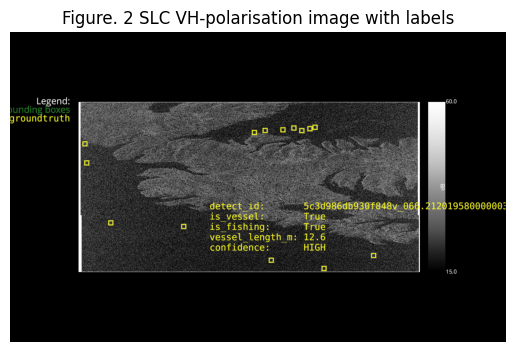

In [28]:
# Capture and display the same image inline using matplotlib
import matplotlib.pyplot as plt

img = plot_SLC.render()  # Capture the VisPy canvas as an image
plt.title("Figure. 2 SLC VH-polarisation image with labels")
plt.imshow(img)
plt.axis('off')
plt.show()

plot_SLC = None # free memory

Figure 2 above, is the scaled, clipped and downsampled version of the SLC VH-polarisation product for scene_id '5c3d986db930f848v' (swath 2). The complex amplitude and phase data have been mapped into real intensity values for the display. Yellow boxes represent the bounding-boxes of the groundtruth labels, representing fishing vessels or non-fishing-vessels and where confidence = 'HIGH'.

## 5. Pre-processing

### 5.1 Image crops

Generate 64 x 64 pixel image crops from the raw image arrays saved to disk in Section 4.1. Each crop should be centred on a positive vessel detection location, with confidence level HIGH or MEDIUM, and encompassed by a bounding box.

Note: True postive vessel detections with bounding boxes that extend beyond the original image boundary are skipped.

In [29]:
# Create image crops - see cropping.yaml for configuration parameters.
#!./cropping/create_crop.py > crops_log

In [1]:
# Open and read the file
with open('./cropping/crops_log', 'r') as file:
    content = file.read()

# Display the content
#print(content)

From Section 4.2, we saw there are a total of 3,857 positive vessel detection labels that fit the criteria defined in Secton 2.2. The *crops_log* indicates image crops were created for 3,490 labels while the bounding boxes for 367 detections fell outside of the image boundaries and image crops were not created for these. A further 14 individual swaths failed the label validation meaning no qualifying labels were present in the annotations file for that particular image. This makes sense as we saw earlier in Section 4.2, of the 50 qualifying scenes comprising a total of 150 images (3 swaths per scene), only 136 images had 'HIGH' or 'MEDIUM' confidence for positive vessel detections annotations.

### 5.2 Interactive visual crop reconnaissance tool

An interactive tool to visualise the extracted crops was developed. The tool offers a selection of display modes, including unscaled and decibel-scaled magnitude, phase, sin(phase), cos(phase), real and imaginary. Bounding boxes are also displayed with the class of the detected object indicated ('is_fishing' or 'is_vessel').

In [35]:
!./cropping/verify_crops.py --images /mnt/h/SARFish/SLC/validation/extracted_crops/images --labels /mnt/h/SARFish/SLC/validation/extracted_crops/labels -m magnitude

Navigation:
  → : next crop
  ← : previous crop
  ↑ : next display mode
  ↓ : previous display mode
  Esc : quit

Display modes: magnitude, log_magnitude, phase, sin_phase, cos_phase, real, imag
Total files: 3490


### 5.2 Scaling and normalisation

In [36]:
# Display the core processing script command line parameters and usage examples for standalone use
!./complex_scale_and_norm.py --help

usage: complex_scale_and_norm.py [-h] [--output-dir OUTPUT_DIR]
                                 [--nan-strategy {skip,zero,mean,interpolate}]
                                 [--epsilon EPSILON]
                                 [--global-norm-params AMP_MIN AMP_MAX]
                                 [--verbose]
                                 input_array

Process complex-valued SAR data into normalised 3-channel format for YOLO

positional arguments:
  input_array           Path to input numpy array file (.npy)

options:
  -h, --help            show this help message and exit
  --output-dir OUTPUT_DIR
                        Output directory (default: current working directory)
  --nan-strategy {skip,zero,mean,interpolate}
                        Strategy for handling NaN/invalid values (default:
                        skip)
  --epsilon EPSILON     Small value to prevent log(0) in amplitude processing
                        (default: 1e-6)
  --global-norm-params AMP_MIN AMP_MAX
    

In [ ]:
!./complex_scale_and_norm.py '/mnt/h/SARFish/SLC/validation/extracted_crops/images/' --global-norm-params 0.0 22862.6 

In [ ]:
test_proc = np.load('/mnt/h/SARFish/SLC/staging/0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_proc.npy')

In [ ]:
slc_norm_vitals = {
    "size": test_proc.size, 
    "shape": test_proc.shape, 
    "dtype": test_proc.dtype, 
    "amp_min": np.min(test_proc[:, :, 0]), 
    "amp_max": np.max(test_proc[:, :, 0]), 
    "phase_min": np.min(test_proc[:, :, 1]), 
    "phase_max": np.max(test_proc[:, :, 1])
}
slc_norm_vitals

Batch process the image crops created in Section 5.1 using the `batch_process_sar_data() function` which calls the `complex_scale_and_norm.py` script:

In [ ]:
# Processing with global normalisation parameters
print("=== GLOBAL NORMALIZATION PROCESSING ===")

# Configure processing parameters
config = setup_global_norm_processing() # processing mode
#config.input_dir = "/mnt/h/SARFish/SLC/validation/extracted_crops/images/"
config.input_dir = "/mnt/h/SARFish/SLC/staging"
config.output_dir = "/mnt/h/SARFish/SLC/validation/extracted_crops/images_proc2/"
config.global_norm_params = [0.0, 22862.6] # global processing prameters
config.verbose = False
config.max_workers = 4 # parallel processing with a maximum of 4 workers

print("Global normalization parameters:")
print(f"  Amplitude range (unscaled): {config.global_norm_params[0]} to {config.global_norm_params[1]}")
#print(f"  Phase range (radians): {config.global_norm_params[2]} to {config.global_norm_params[3]}")

# Initiate batch processing of image crops
batch_process_sar_data(config)

Load one example of an output scaled and normalised image crop array and display its vital stats:

In [ ]:
# Load a single normalised crop image
slc_crop_norm = np.load("/mnt/h/SARFish/SLC/validation/extracted_crops/images_proc/0d8ed29b0760dc59v_043.21094381000000339554_015.15049506000000079098_swath1_proc.npy")

In [ ]:
# Compute some vital statistics of the normalised crop image
slc_crop_norm_vitals = {
    "size": slc_crop_norm.size, 
    "shape": slc_crop_norm.shape, 
    "dtype": slc_crop_norm.dtype, 
    "amp_min": np.min(slc_crop_norm[:, :, 0]), 
    "amp_max": np.max(slc_crop_norm[:, :, 0]), 
    "phase_min": np.min(slc_crop_norm[:, :, 1]), 
    "phase_max": np.max(slc_crop_norm[:, :, 1])
}
slc_crop_norm_vitals

### 5.3 Data augmentation

## 6. Modelling

#### Load the model

In [ ]:
from ultralytics import YOLO
import torch

In [ ]:
# Load the model
model = YOLO('yolo11n.pt')

#### Verify installation

In [ ]:
# Run inference on an image
results = model('https://ultralytics.com/images/bus.jpg')

In [ ]:
# Print detailed results with bounding boxes and confidence
for r in results:
    print(f"Detected {len(r.boxes)} objects")
    
    # Access bounding box information
    if r.boxes is not None:
        boxes = r.boxes.xyxy  # bounding boxes in xyxy format
        confidences = r.boxes.conf  # confidence scores
        classes = r.boxes.cls  # class indices
        
        print("\nDetailed detections:")
        for i, (box, conf, cls_idx) in enumerate(zip(boxes, confidences, classes)):
            x1, y1, x2, y2 = box.tolist()
            class_name = r.names[int(cls_idx)]
            
            print(f"Object {i+1}:")
            print(f"  Class: {class_name} (ID: {int(cls_idx)})")
            print(f"  Confidence: {conf:.4f}")
            print(f"  Bounding box: ({x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f})")
            print(f"  Box format: (x1, y1, x2, y2)")
            print()

In [ ]:
# Save results with bounding boxes drawn
results[0].save('output_with_boxes.jpg')

In [ ]:
# Access the underlying PyTorch model
pytorch_model = model.model

#### Examine the architecture

In [ ]:
# View the model architecture
print(pytorch_model)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import gc
from typing import List, Tuple, Dict, Optional

def analyze_vessel_crop(complex_crop, crop_id=None, center_radius=10):
    """
    Analyze a single 64x64 vessel crop to extract vessel and background characteristics.
    
    Parameters:
    -----------
    complex_crop : numpy.ndarray
        64x64 complex-valued SAR crop with vessel at center
    crop_id : str, optional
        Identifier for this crop
    center_radius : int
        Radius around center to consider as vessel region
    
    Returns:
    --------
    dict : Analysis results including vessel/background statistics
    """
    h, w = complex_crop.shape
    center_x, center_y = w // 2, h // 2
    
    # Create masks for vessel (center) and background regions
    y_coords, x_coords = np.ogrid[:h, :w]
    vessel_mask = ((x_coords - center_x)**2 + (y_coords - center_y)**2) <= center_radius**2
    background_mask = ~vessel_mask
    
    # Extract amplitude and phase
    amplitude = np.abs(complex_crop)
    phase = np.angle(complex_crop)
    
    # Vessel statistics
    vessel_amp = amplitude[vessel_mask]
    vessel_phase = phase[vessel_mask]
    
    # Background statistics  
    bg_amp = amplitude[background_mask]
    bg_phase = phase[background_mask]
    
    # Remove invalid values
    vessel_amp = vessel_amp[np.isfinite(vessel_amp) & (vessel_amp > 0)]
    vessel_phase = vessel_phase[np.isfinite(vessel_phase)]
    bg_amp = bg_amp[np.isfinite(bg_amp) & (bg_amp > 0)]
    bg_phase = bg_phase[np.isfinite(bg_phase)]
    
    return {
        'crop_id': crop_id,
        'vessel_amp_mean': np.mean(vessel_amp) if len(vessel_amp) > 0 else 0,
        'vessel_amp_std': np.std(vessel_amp) if len(vessel_amp) > 0 else 0,
        'vessel_amp_max': np.max(vessel_amp) if len(vessel_amp) > 0 else 0,
        'bg_amp_mean': np.mean(bg_amp) if len(bg_amp) > 0 else 0,
        'bg_amp_std': np.std(bg_amp) if len(bg_amp) > 0 else 0,
        'contrast_ratio': (np.mean(vessel_amp) / np.mean(bg_amp)) if len(bg_amp) > 0 and np.mean(bg_amp) > 0 else 0,
        'vessel_pixels': len(vessel_amp),
        'bg_pixels': len(bg_amp),
        'vessel_phase_var': np.var(vessel_phase) if len(vessel_phase) > 0 else 0,
        'bg_phase_var': np.var(bg_phase) if len(bg_phase) > 0 else 0
    }

def create_crop_histogram(complex_crops, crop_ids=None, n_bins_phase=64, n_bins_amp=32,
                         analysis_type='vessel_focused', center_radius=10):
    """
    Create phase-amplitude histogram for vessel crops.
    
    Parameters:
    -----------
    complex_crops : list or numpy.ndarray
        List of 64x64 complex crops, or single 3D array (N, 64, 64)
    crop_ids : list, optional
        Identifiers for each crop
    n_bins_phase : int
        Number of phase bins
    n_bins_amp : int  
        Number of amplitude bins
    analysis_type : str
        'vessel_focused' - Focus on vessel regions only
        'full_crop' - Analyze entire crop
        'comparative' - Compare vessel vs background
    center_radius : int
        Radius for vessel region definition
    """
    
    # Handle input format
    if isinstance(complex_crops, np.ndarray):
        if complex_crops.ndim == 2:
            complex_crops = [complex_crops]
        elif complex_crops.ndim == 3:
            complex_crops = [complex_crops[i] for i in range(complex_crops.shape[0])]
    
    n_crops = len(complex_crops)
    if crop_ids is None:
        crop_ids = [f"Crop_{i:03d}" for i in range(n_crops)]
    
    print(f"Processing {n_crops} vessel crops...")
    
    # Collect statistics for all crops
    crop_stats = []
    all_vessel_amp = []
    all_vessel_phase = []
    all_bg_amp = []
    all_bg_phase = []
    
    for i, crop in enumerate(complex_crops):
        if crop.shape != (64, 64):
            print(f"Warning: Crop {i} has shape {crop.shape}, expected (64, 64)")
            continue
            
        stats = analyze_vessel_crop(crop, crop_ids[i], center_radius)
        crop_stats.append(stats)
        
        # Extract vessel and background data
        h, w = crop.shape
        center_x, center_y = w // 2, h // 2
        y_coords, x_coords = np.ogrid[:h, :w]
        vessel_mask = ((x_coords - center_x)**2 + (y_coords - center_y)**2) <= center_radius**2
        
        amplitude = np.abs(crop)
        phase = np.angle(crop)
        
        if analysis_type == 'vessel_focused':
            vessel_amp_crop = amplitude[vessel_mask]
            vessel_phase_crop = phase[vessel_mask]
            valid_mask = np.isfinite(vessel_amp_crop) & (vessel_amp_crop > 0) & np.isfinite(vessel_phase_crop)
            all_vessel_amp.extend(vessel_amp_crop[valid_mask])
            all_vessel_phase.extend(vessel_phase_crop[valid_mask])
            
        elif analysis_type == 'full_crop':
            amp_flat = amplitude.ravel()
            phase_flat = phase.ravel()
            valid_mask = np.isfinite(amp_flat) & (amp_flat > 0) & np.isfinite(phase_flat)
            all_vessel_amp.extend(amp_flat[valid_mask])
            all_vessel_phase.extend(phase_flat[valid_mask])
            
        else:  # comparative
            # Vessel region
            vessel_amp_crop = amplitude[vessel_mask]
            vessel_phase_crop = phase[vessel_mask]
            valid_vessel = np.isfinite(vessel_amp_crop) & (vessel_amp_crop > 0) & np.isfinite(vessel_phase_crop)
            all_vessel_amp.extend(vessel_amp_crop[valid_vessel])
            all_vessel_phase.extend(vessel_phase_crop[valid_vessel])
            
            # Background region  
            bg_amp_crop = amplitude[~vessel_mask]
            bg_phase_crop = phase[~vessel_mask]
            valid_bg = np.isfinite(bg_amp_crop) & (bg_amp_crop > 0) & np.isfinite(bg_phase_crop)
            all_bg_amp.extend(bg_amp_crop[valid_bg])
            all_bg_phase.extend(bg_phase_crop[valid_bg])
    
    # Convert to numpy arrays
    all_vessel_amp = np.array(all_vessel_amp)
    all_vessel_phase = np.array(all_vessel_phase)
    
    if len(all_vessel_amp) == 0:
        print("Error: No valid vessel pixels found!")
        return None, None, None
    
    print(f"Collected {len(all_vessel_amp):,} vessel pixels from {n_crops} crops")
    if analysis_type == 'comparative':
        print(f"Collected {len(all_bg_amp):,} background pixels")
        print(f"Vessel amplitude range: {np.min(all_vessel_amp):.4f} - {np.max(all_vessel_amp):.4f}")
        if len(all_bg_amp) > 0:
            print(f"Background amplitude range: {np.min(all_bg_amp):.4f} - {np.max(all_bg_amp):.4f}")
    
    # Phase bins
    phase_edges = np.linspace(-np.pi, np.pi, n_bins_phase + 1)
    
    # Create histograms
    if analysis_type == 'comparative' and len(all_bg_amp) > 0:
        all_bg_amp = np.array(all_bg_amp)
        all_bg_phase = np.array(all_bg_phase)
        
        # For comparative analysis, create amplitude bins that cover both vessel and background
        combined_amp = np.concatenate([all_vessel_amp, all_bg_amp])
        amp_min = np.percentile(combined_amp, 1)
        amp_max = np.percentile(combined_amp, 99.5)
        
        # Ensure minimum value is positive for log scale
        amp_min = max(amp_min, 1e-6)
        amp_max = max(amp_max, amp_min * 10)  # Ensure meaningful range
        
        print(f"Combined amplitude range for binning: {amp_min:.6f} - {amp_max:.6f}")
        
        try:
            amp_edges = np.logspace(np.log10(amp_min), np.log10(amp_max), n_bins_amp + 1)
        except ValueError as e:
            print(f"Error creating log bins: {e}")
            print("Falling back to linear binning")
            amp_edges = np.linspace(amp_min, amp_max, n_bins_amp + 1)
        
        # Create separate histograms for vessel and background
        hist_vessel, _, _ = np.histogram2d(all_vessel_phase, all_vessel_amp, 
                                         bins=[phase_edges, amp_edges])
        hist_bg, _, _ = np.histogram2d(all_bg_phase, all_bg_amp,
                                     bins=[phase_edges, amp_edges])
    else:
        # Create amplitude bins - adaptive to vessel data range only
        amp_min = np.percentile(all_vessel_amp, 1)
        amp_max = np.percentile(all_vessel_amp, 99.5)
        
        # Ensure minimum value is positive for log scale
        amp_min = max(amp_min, 1e-6)
        amp_max = max(amp_max, amp_min * 10)  # Ensure meaningful range
        
        try:
            amp_edges = np.logspace(np.log10(amp_min), np.log10(amp_max), n_bins_amp + 1)
        except ValueError as e:
            print(f"Error creating log bins: {e}")
            print("Falling back to linear binning")
            amp_edges = np.linspace(amp_min, amp_max, n_bins_amp + 1)
        
        # Create visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Vessel histogram
        im1 = ax1.imshow(hist_vessel.T + 1, extent=[-np.pi, np.pi, 0, n_bins_amp],
                        origin='lower', aspect='auto', cmap='hot', norm=LogNorm())
        ax1.set_title(f'Vessel Regions (n={n_crops} crops)')
        ax1.set_xlabel('Phase (radians)')
        ax1.set_ylabel('Amplitude Bin')
        plt.colorbar(im1, ax=ax1, label='Frequency')
        
        # Background histogram
        im2 = ax2.imshow(hist_bg.T + 1, extent=[-np.pi, np.pi, 0, n_bins_amp],
                        origin='lower', aspect='auto', cmap='blues', norm=LogNorm())
        ax2.set_title('Background Regions')
        ax2.set_xlabel('Phase (radians)')
        ax2.set_ylabel('Amplitude Bin')
        plt.colorbar(im2, ax=ax2, label='Frequency')
        
        # Phase comparison
        phase_centers = (phase_edges[:-1] + phase_edges[1:]) / 2
        vessel_phase_dist = np.sum(hist_vessel, axis=1)
        bg_phase_dist = np.sum(hist_bg, axis=1)
        
        ax3.plot(phase_centers, vessel_phase_dist, 'r-', label='Vessel', linewidth=2)
        ax3.plot(phase_centers, bg_phase_dist, 'b-', label='Background', linewidth=2)
        ax3.set_xlabel('Phase (radians)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Phase Distribution Comparison')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Amplitude comparison
        amp_centers = np.sqrt(amp_edges[:-1] * amp_edges[1:])
        vessel_amp_dist = np.sum(hist_vessel, axis=0)
        bg_amp_dist = np.sum(hist_bg, axis=0)
        
        ax4.loglog(amp_centers, vessel_amp_dist + 1, 'r-', label='Vessel', linewidth=2)
        ax4.loglog(amp_centers, bg_amp_dist + 1, 'b-', label='Background', linewidth=2)
        ax4.set_xlabel('Amplitude')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Amplitude Distribution Comparison')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        main_hist = hist_vessel
        
    else:
        # Single histogram
        hist_2d, _, _ = np.histogram2d(all_vessel_phase, all_vessel_amp,
                                     bins=[phase_edges, amp_edges])
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Main histogram
        im1 = ax1.imshow(hist_2d.T + 1, extent=[-np.pi, np.pi, 0, n_bins_amp],
                        origin='lower', aspect='auto', cmap='plasma', norm=PowerNorm(gamma=0.5))
        title = f'Vessel Crops Phase-Amplitude ({analysis_type})'
        ax1.set_title(title)
        ax1.set_xlabel('Phase (radians)')
        ax1.set_ylabel('Amplitude Bin')
        plt.colorbar(im1, ax=ax1, label='Frequency')
        
        # Phase distribution
        phase_centers = (phase_edges[:-1] + phase_edges[1:]) / 2
        phase_dist = np.sum(hist_2d, axis=1)
        ax2.plot(phase_centers, phase_dist, 'g-', linewidth=2)
        ax2.set_xlabel('Phase (radians)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Phase Distribution')
        ax2.grid(True, alpha=0.3)
        
        # Amplitude distribution
        amp_centers = np.sqrt(amp_edges[:-1] * amp_edges[1:])
        amp_dist = np.sum(hist_2d, axis=0)
        ax3.loglog(amp_centers, amp_dist + 1, 'purple', linewidth=2)
        ax3.set_xlabel('Amplitude')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Amplitude Distribution')
        ax3.grid(True, alpha=0.3)
        
        # Crop statistics summary
        if crop_stats:
            contrast_ratios = [s['contrast_ratio'] for s in crop_stats if s['contrast_ratio'] > 0]
            vessel_amps = [s['vessel_amp_mean'] for s in crop_stats if s['vessel_amp_mean'] > 0]
            
            ax4.hist(contrast_ratios, bins=20, alpha=0.7, color='orange', edgecolor='black')
            ax4.set_xlabel('Vessel/Background Contrast Ratio')
            ax4.set_ylabel('Number of Crops')
            ax4.set_title(f'Contrast Distribution (n={len(contrast_ratios)})')
            ax4.grid(True, alpha=0.3)
        
        main_hist = hist_2d
    
    # Format phase ticks
    phase_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
    phase_labels = ['-π', '-π/2', '0', 'π/2', 'π']
    for ax in fig.get_axes():
        if 'Phase' in ax.get_xlabel():
            ax.set_xticks(phase_ticks)
            ax.set_xticklabels(phase_labels)
    
    plt.tight_layout()
    
    # Summary statistics
    summary = {
        'n_crops': n_crops,
        'total_pixels': len(all_vessel_amp),
        'amp_range': (np.min(all_vessel_amp), np.max(all_vessel_amp)),
        'mean_contrast': np.mean([s['contrast_ratio'] for s in crop_stats if s['contrast_ratio'] > 0]),
        'crop_stats': crop_stats
    }
    
    return fig, main_hist, summary

def batch_process_crops(crop_directory=None, complex_crops=None, **kwargs):
    """
    Batch process multiple vessel crops.
    
    Parameters:
    -----------
    crop_directory : str, optional
        Directory containing .npy files of crops
    complex_crops : list/array, optional  
        Direct array of crops
    **kwargs : additional arguments for create_crop_histogram
    """
    
    if crop_directory is not None:
        import os
        crop_files = [f for f in os.listdir(crop_directory) if f.endswith('.npy')]
        crop_ids = [f.replace('.npy', '') for f in crop_files]
        complex_crops = [np.load(os.path.join(crop_directory, f)) for f in crop_files]
        print(f"Loaded {len(complex_crops)} crops from {crop_directory}")
    
    elif complex_crops is None:
        print("Error: Must provide either crop_directory or complex_crops")
        return None
        
    return create_crop_histogram(complex_crops, crop_ids, **kwargs)

# Example usage
if __name__ == "__main__":
    # Example: Create synthetic vessel crops for testing
    print("Creating example vessel crops...")
    
    # Generate synthetic 64x64 crops with vessels at center
    n_test_crops = 5
    test_crops = []
    
    for i in range(n_test_crops):
        # Create background sea clutter
        crop = (np.random.randn(64, 64) + 1j * np.random.randn(64, 64)) * 0.5
        
        # Add vessel signature at center
        center_x, center_y = 32, 32
        vessel_size = np.random.randint(6, 12)
        vessel_amp = np.random.uniform(3, 8)
        
        y_coords, x_coords = np.ogrid[:64, :64]
        vessel_mask = ((x_coords - center_x)**2 + (y_coords - center_y)**2) <= vessel_size**2
        
        # Add vessel with higher amplitude and specific phase pattern
        vessel_phase = np.random.uniform(-np.pi, np.pi)
        crop[vessel_mask] = vessel_amp * np.exp(1j * vessel_phase)
        
        test_crops.append(crop)
    
    # Test different analysis types
    analysis_types = ['vessel_focused', 'full_crop', 'comparative']
    
    for analysis in analysis_types:
        print(f"\n{'='*50}")
        print(f"Analysis type: {analysis}")
        print('='*50)
        
        fig, hist, summary = create_crop_histogram(
            test_crops,
            analysis_type=analysis,
            n_bins_phase=32,
            n_bins_amp=24,
            center_radius=8
        )
        
        if summary:
            print(f"Processed {summary['n_crops']} crops")
            print(f"Total pixels analyzed: {summary['total_pixels']:,}")
            print(f"Amplitude range: {summary['amp_range'][0]:.2f} - {summary['amp_range'][1]:.2f}")
            print(f"Mean contrast ratio: {summary['mean_contrast']:.2f}")
        
        plt.show()
        
        cont = input("Continue to next analysis? (y/n): ")
        if not cont.lower().startswith('y'):
            break